In [2]:
import pandas as pd
import sqlite_utils
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import datetime

In [3]:
def clean_fips(fips):
    if pd.isnull(fips):
        return "-1"
    else:
        return ("00000" + str(int(fips)))[-5:]

In [4]:
# NYC FIPS CODES TO CONSOLIDATE INTO NYC GEOGRAPHY
NYC_FIPS = ["36061", "36005", "36081", "36047", "36085"]

In [5]:
# 2018 POPULATION ESTIMATES
pop = pd.read_csv(
    "https://www.ers.usda.gov/webdocs/DataFiles/48747/PopulationEstimates.csv?v=3011.3",
    encoding="cp1251",
)

# FILTER OUT STATES AND US POPULATIONS
pop = pop.loc[pop["Rural-urban_Continuum Code_2003"].notnull()]

# CONVIRT FIPS INTS TO 5-DIGIT CODES
pop.loc[:, "FIPS"] = pop.loc[:, "FIPS"].apply(clean_fips)
pop.rename(columns={"FIPS": "fips"}, inplace=True)
pop.loc[:, "fips"] = pop.fips.apply(lambda x: "00000" if x in NYC_FIPS else x)

pop = pop.loc[:, ["POP_ESTIMATE_2018", "fips"]].copy()
pop.loc[:, "POP_ESTIMATE_2018"] = pop["POP_ESTIMATE_2018"].apply(
    lambda x: int(x.replace(",", ""))
)
# MAKE NYC GEOGRAPHY a total of 8million plus
pop = pop.groupby("fips").sum().reset_index()

In [6]:
# tiger shape file https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/
shapefile = gpd.read_file("shapefile/tl_2019_us_county/tl_2019_us_county.shp")
# convert lat and long to decimal
shapefile.loc[:, "INTPTLAT"] = shapefile.INTPTLAT.apply(lambda x: float(x[1:]))
shapefile.loc[:, "INTPTLON"] = shapefile.INTPTLON.apply(float)

# make fips code 5 digit string
shapefile.loc[:, "fips"] = shapefile.GEOID.apply(
    lambda x: "00000" if x in NYC_FIPS else x
)

# MAKE NYC into a single geography
shapefile = shapefile.dissolve(by="fips")

shapefile.reset_index(inplace=True)

# primitive continental US filter
shapefile = shapefile.loc[
    (shapefile["INTPTLAT"] > 25)
    & (shapefile["INTPTLON"] < 0)
    & (shapefile["INTPTLON"] > -130)
]

In [7]:
# NY TIMES data updated daily
covid_df = pd.read_csv(
    "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
)
covid_df.loc[:, "fips"] = covid_df["fips"].apply(clean_fips)
covid_df.loc[covid_df["county"] == "New York City", "fips"] = "00000"
covid_df = covid_df.merge(pop, how="left", on="fips")
covid_df.loc[:, "cases_per_100000"] = (
    covid_df.cases / covid_df.POP_ESTIMATE_2018 * 100000
)
covid_df.loc[:, "deaths_per_100000"] = (
    covid_df.deaths / covid_df.POP_ESTIMATE_2018 * 100000
)

In [8]:
state_shapefile = gpd.read_file("shapefile/tl_2019_us_state/tl_2019_us_state.shp")

state_shapefile.loc[:, "INTPTLAT"] = state_shapefile.INTPTLAT.apply(
    lambda x: float(x[1:])
)
state_shapefile.loc[:, "INTPTLON"] = state_shapefile.INTPTLON.apply(float)


state_shapefile = state_shapefile.loc[
    (state_shapefile["INTPTLAT"] > 25)
    & (state_shapefile["INTPTLON"] < 0)
    & (state_shapefile["INTPTLON"] > -130)
]

In [9]:
# SHORTEN NAMES FOR TRISTATE MAP

STATES = {"36": "NY", "09": "CT", "34": "NJ"}

shapefile["STATEFP"].apply(lambda x: STATES.get(x, ""))

shapefile.loc[:, "STATE"] = shapefile["STATEFP"].apply(lambda x: STATES.get(x, ""))

In [10]:
# filter shapefiles for different maps
TRI_STATE = ["09", "34", "36"]
NORTH_EAST = ["25", "00", "33", "34", "36", "42", "50", "09", "23", "44"]

shapefiles = {
    "tristate": [
        shapefile.loc[shapefile.STATEFP.isin(TRI_STATE)],
        state_shapefile.loc[state_shapefile.STATEFP.isin(TRI_STATE)],
    ],
    "us": [shapefile, state_shapefile],
    "northeast": [
        shapefile.loc[shapefile.STATEFP.isin(NORTH_EAST)],
        state_shapefile.loc[state_shapefile.STATEFP.isin(NORTH_EAST)],
    ],
}

In [11]:
metadata = {
    "deaths": {
        "variable": "deaths_per_100000",
        "vmin": 0,
        "vmax": 20,
        "title": "Confirmed COVID-19 Deaths per 100,000 residents",
        "threshold": 20,
    },
    "cases": {
        "variable": "cases_per_100000",
        "vmin": 0,
        "vmax": 500,
        "title": "Confirmed COVID-19 Cases per 100,000 residents",
        "threshold": 500,
    },
}

In [12]:
shapefiles['northeast'][0].head()

fips                                           geometry STATEFP  \
0    00000  MULTIPOLYGON (((-74.25909 40.49956, -74.25909 ...      36   
309  09001  POLYGON ((-73.54362 41.37509, -73.54347 41.376...      09   
310  09003  POLYGON ((-72.94902 41.80643, -72.94894 41.806...      09   
311  09005  POLYGON ((-73.50793 41.79152, -73.50787 41.792...      09   
312  09007  POLYGON ((-72.65367 41.43812, -72.65419 41.438...      09   

    COUNTYFP  COUNTYNS  GEOID        NAME           NAMELSAD LSAD CLASSFP  \
0        085  00974141  36085    Richmond    Richmond County   06      H6   
309      001  00212794  09001   Fairfield   Fairfield County   06      H4   
310      003  00212338  09003    Hartford    Hartford County   06      H4   
311      005  00212796  09005  Litchfield  Litchfield County   06      H4   
312      007  00212797  09007   Middlesex   Middlesex County   06      H4   

     MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND     AWATER   INTPTLAT  \
0    G4020   408  35620    35614        C   148976885  115948458  40.561263   
309  G4020   408  14860     None        N  1618659464  549285481  41.227413   
310  G4020   278  25540     None        N  1903543898   40543777  41.806053   
311  G4020   408  45860     None        N  2384120288   62342856  41.791883   
312  G4020   278  25540     None        N   956493754  180679140  41.433003   

      INTPTLON STATE  
0   -74.139899    NY  
309 -73.367061    CT  
310 -72.732916    CT  
311 -73.235404    CT  
312 -72.522780    CT

In [14]:
covid_df.loc[covid_df.date >= "2020-03-11"]

date      county       state   fips  cases  deaths  \
1160   2020-03-11    Maricopa     Arizona  04013      3       0   
1161   2020-03-11        Pima     Arizona  04019      1       0   
1162   2020-03-11       Pinal     Arizona  04021      5       0   
1163   2020-03-11   Jefferson    Arkansas  05069      1       0   
1164   2020-03-11     Alameda  California  06001     25       0   
...           ...         ...         ...    ...    ...     ...   
86947  2020-04-24    Sublette     Wyoming  56035      1       0   
86948  2020-04-24  Sweetwater     Wyoming  56037     10       0   
86949  2020-04-24       Teton     Wyoming  56039     64       1   
86950  2020-04-24       Uinta     Wyoming  56041      6       0   
86951  2020-04-24    Washakie     Wyoming  56043      4       0   

       POP_ESTIMATE_2018  cases_per_100000  deaths_per_100000  
1160           4410824.0          0.068015           0.000000  
1161           1039073.0          0.096240           0.000000  
1162            447138.0          1.118223           0.000000  
1163             68114.0          1.468127           0.000000  
1164           1666753.0          1.499922           0.000000  
...                  ...               ...                ...  
86947             9813.0         10.190564           0.000000  
86948            43051.0         23.228264           0.000000  
86949            23081.0        277.284346           4.332568  
86950            20299.0         29.558106           0.000000  
86951             7885.0         50.729233           0.000000  

[85792 rows x 9 columns]

/Users/nate/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:525: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/Users/nate/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:525: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/Users/nate/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:525: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pypl

FileNotFoundError: [Errno 2] No such file or directory: 'maps/cases/us/2020-04-10.png'

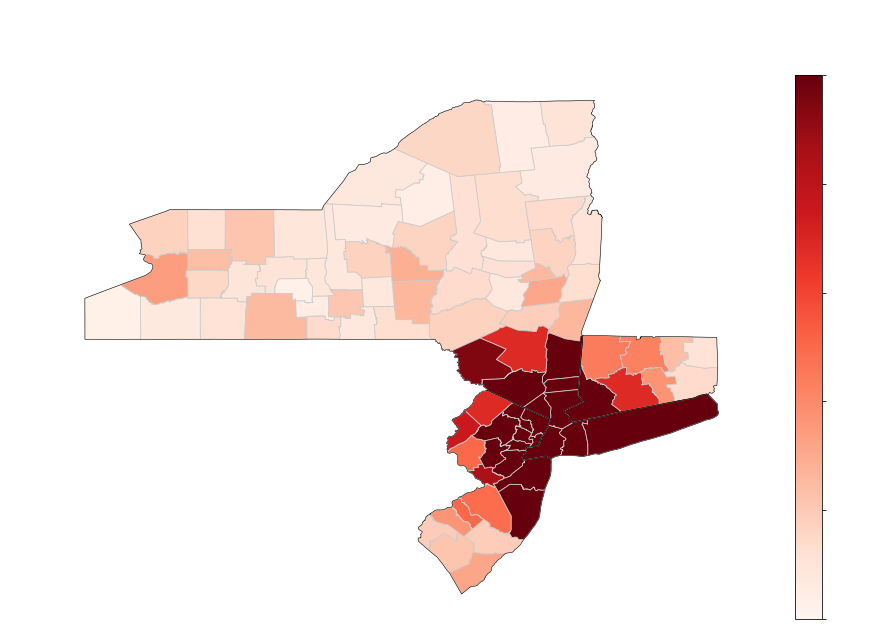

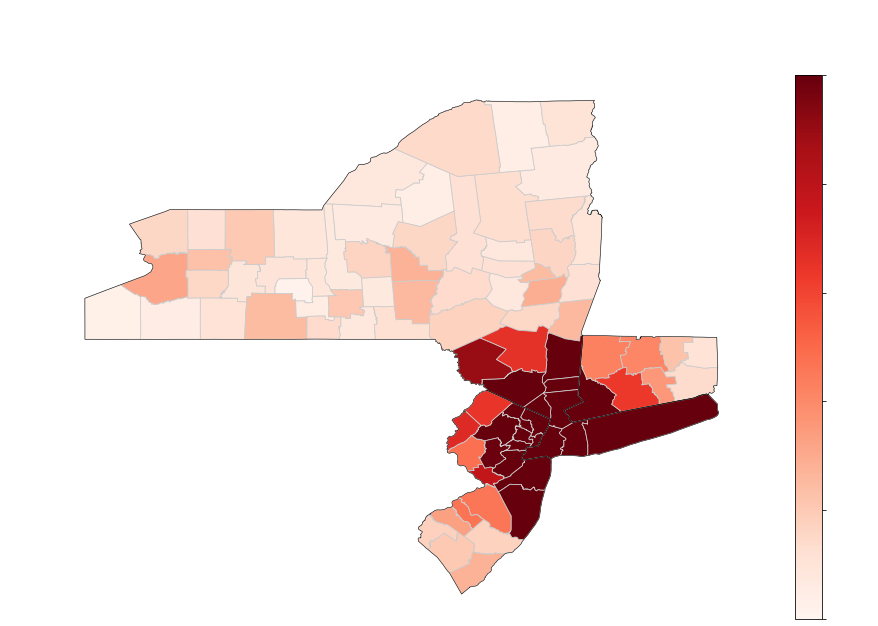

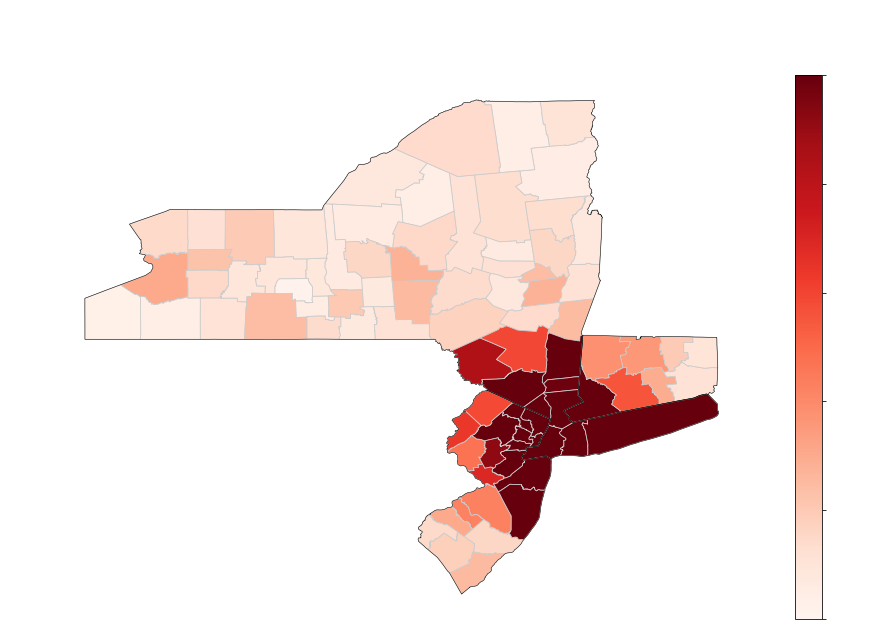

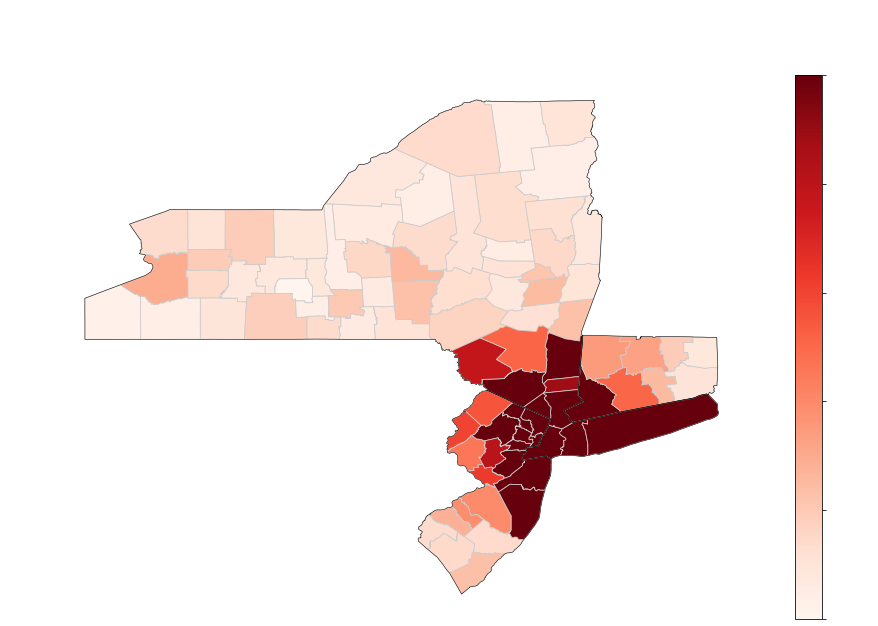

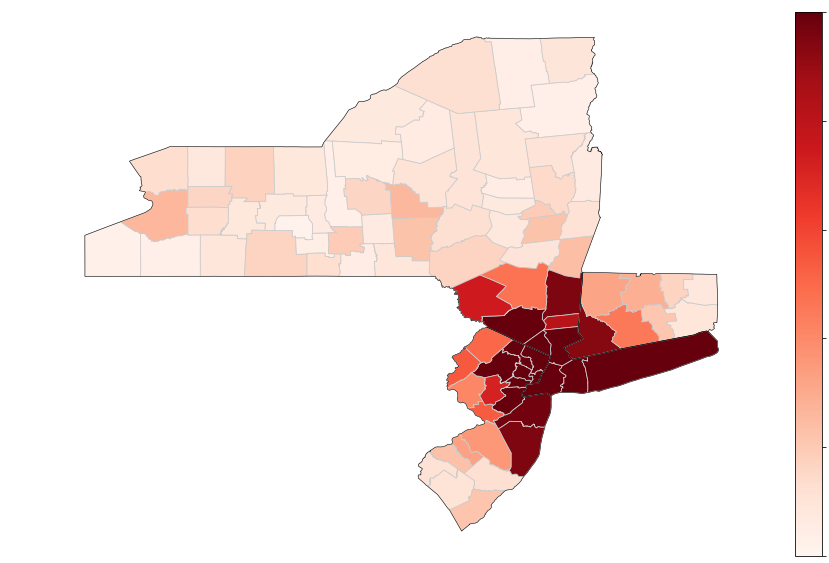

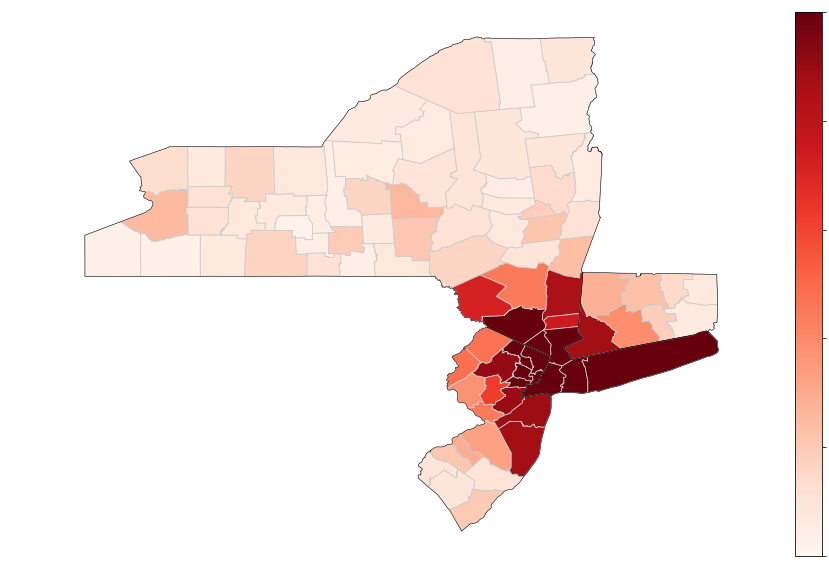

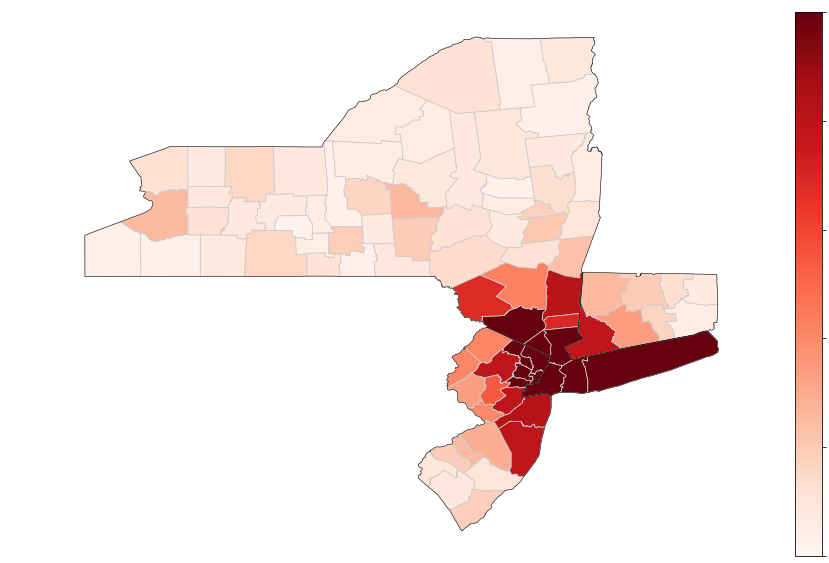

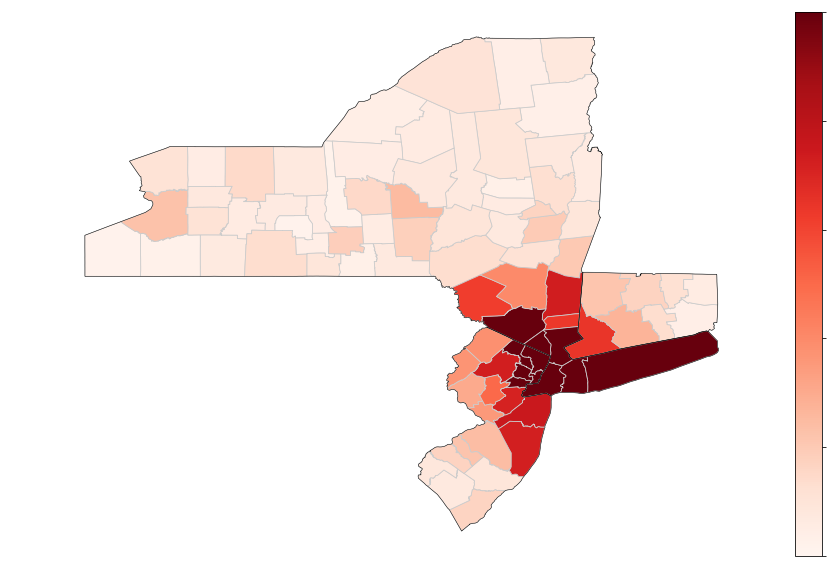

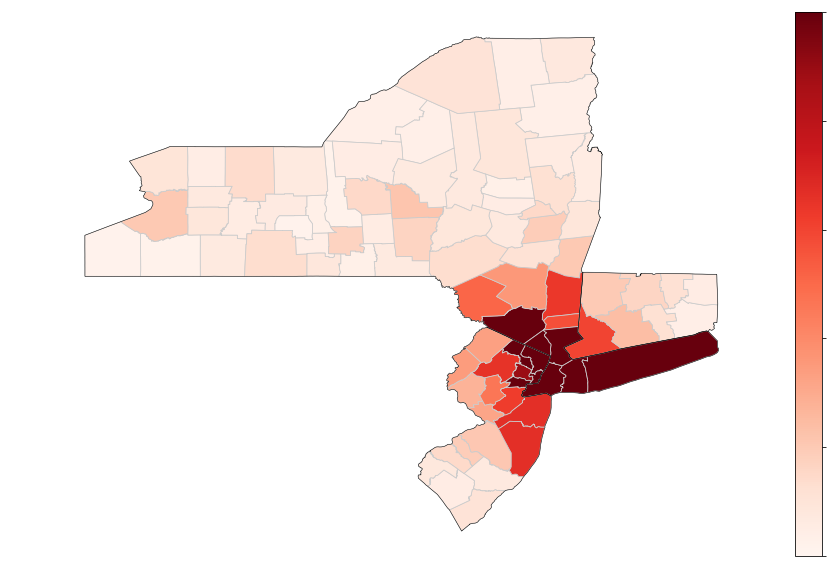

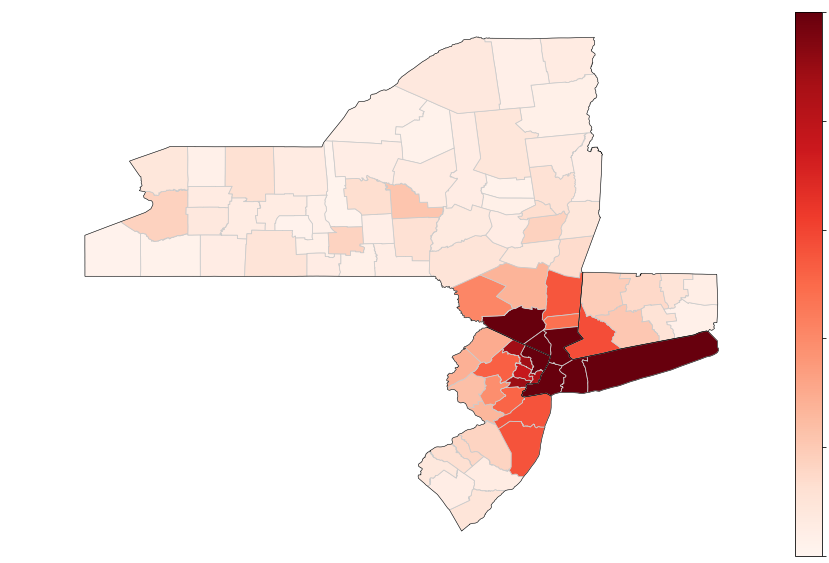

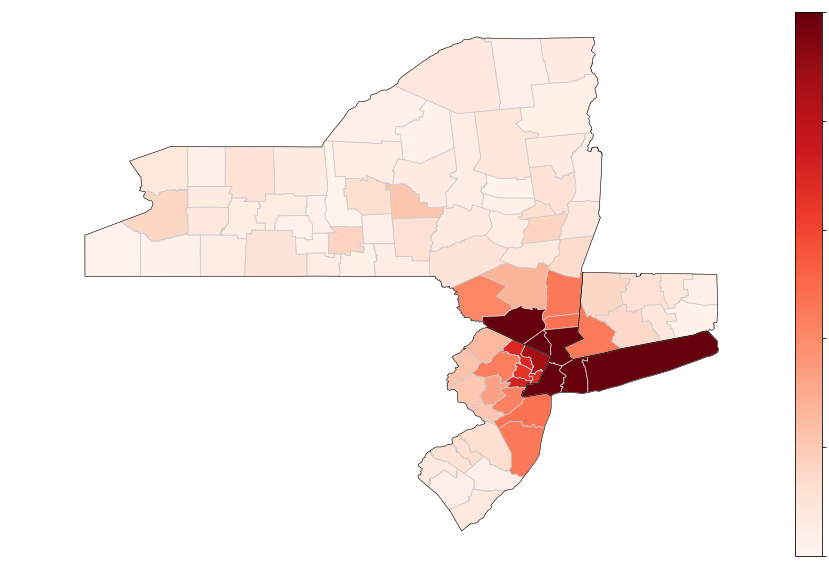

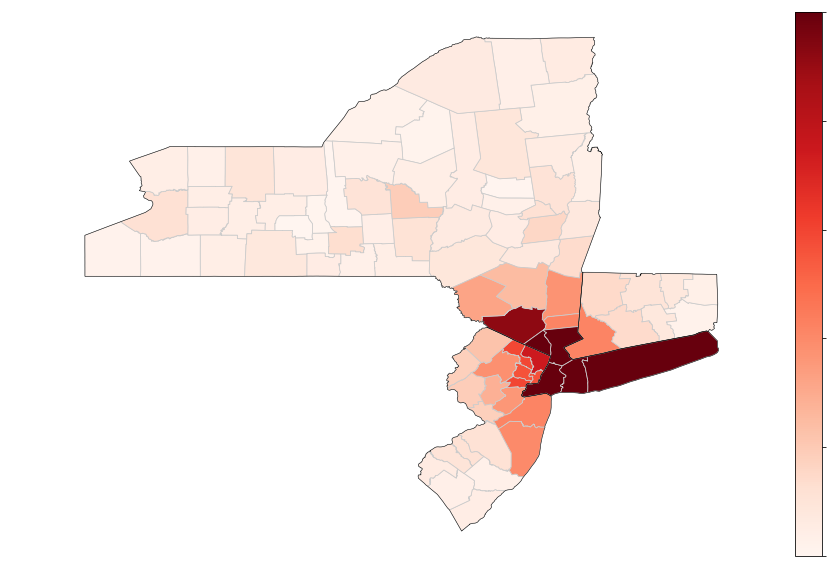

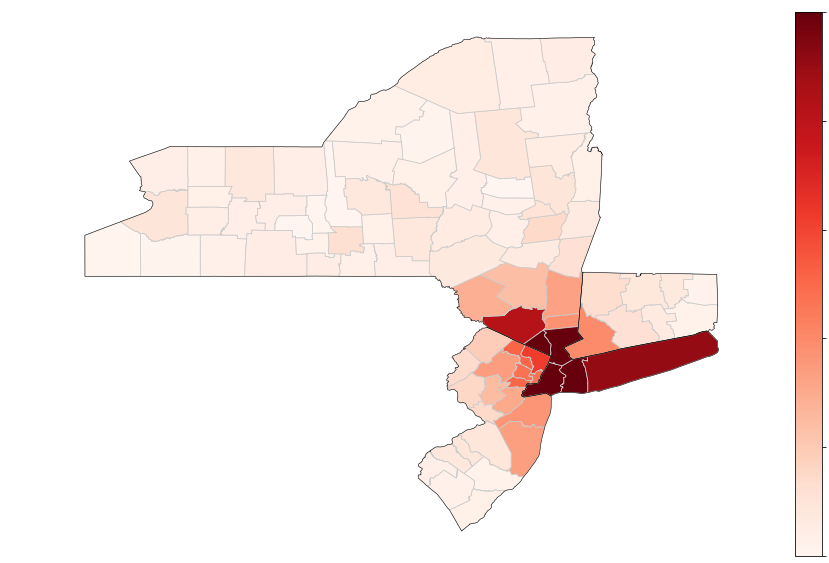

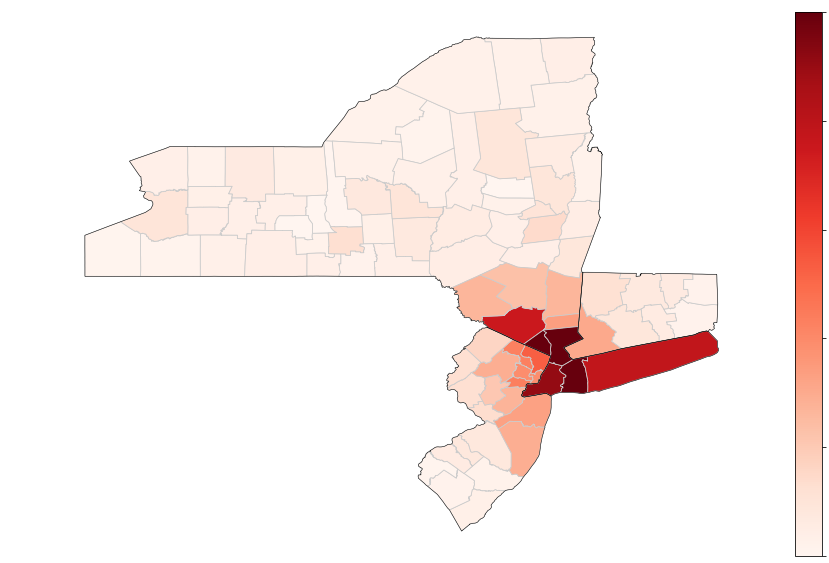

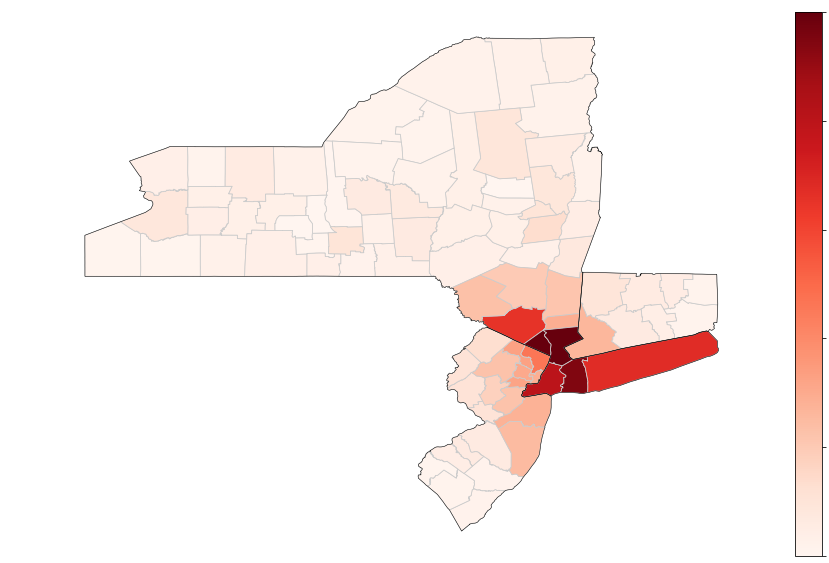

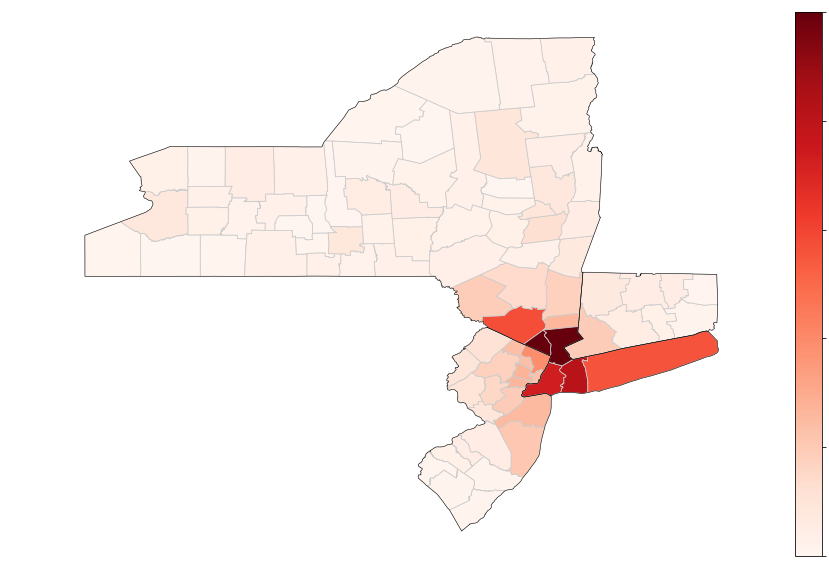

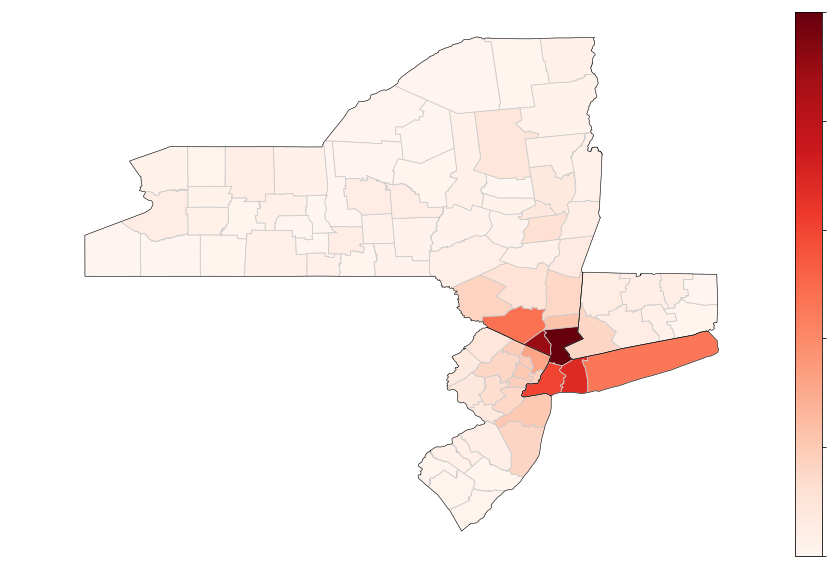

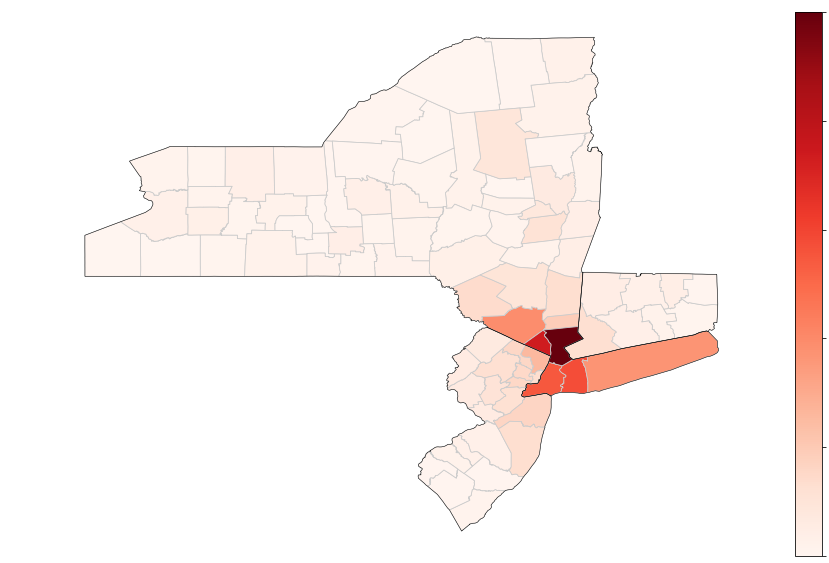

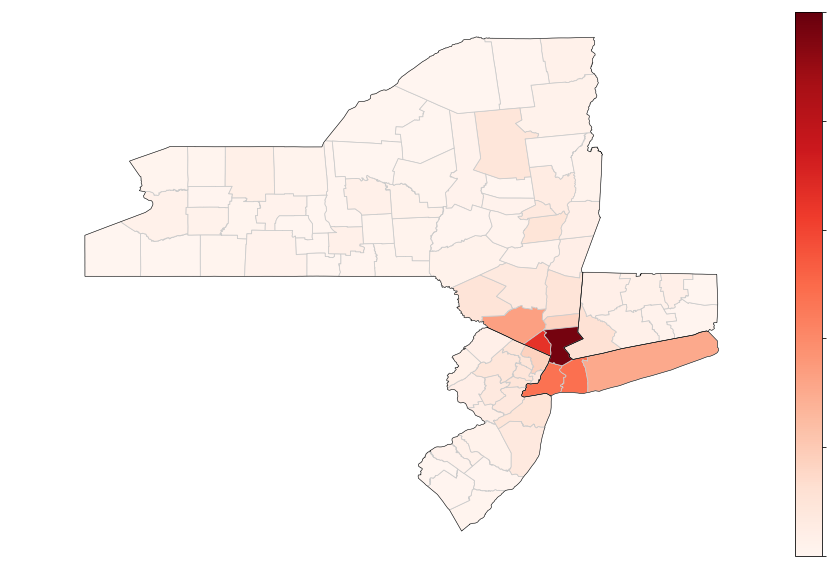

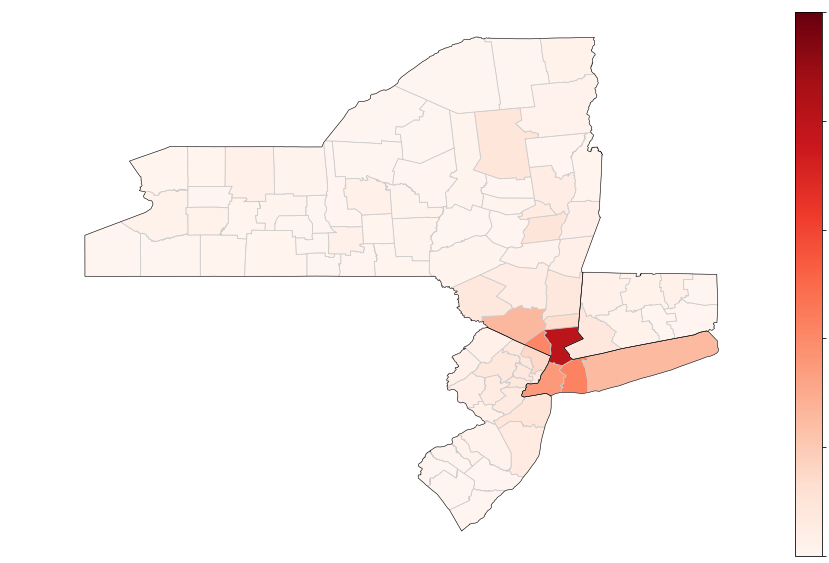

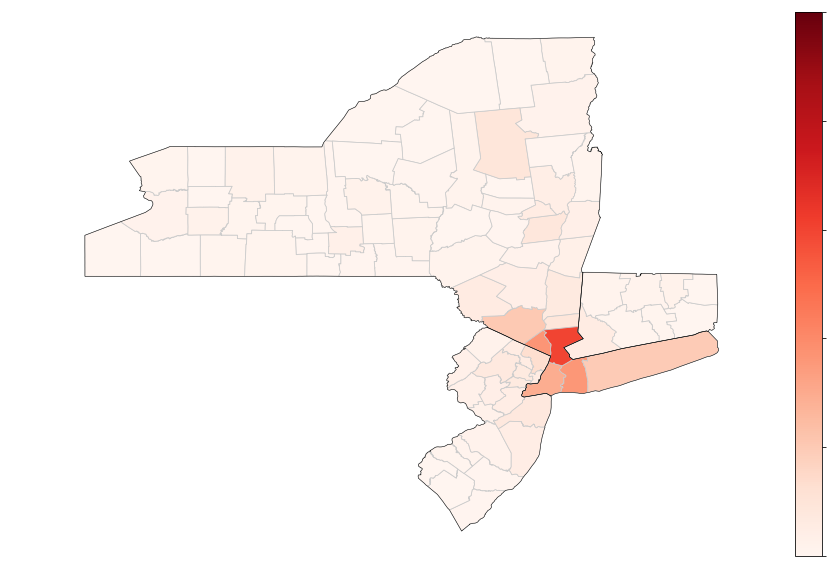

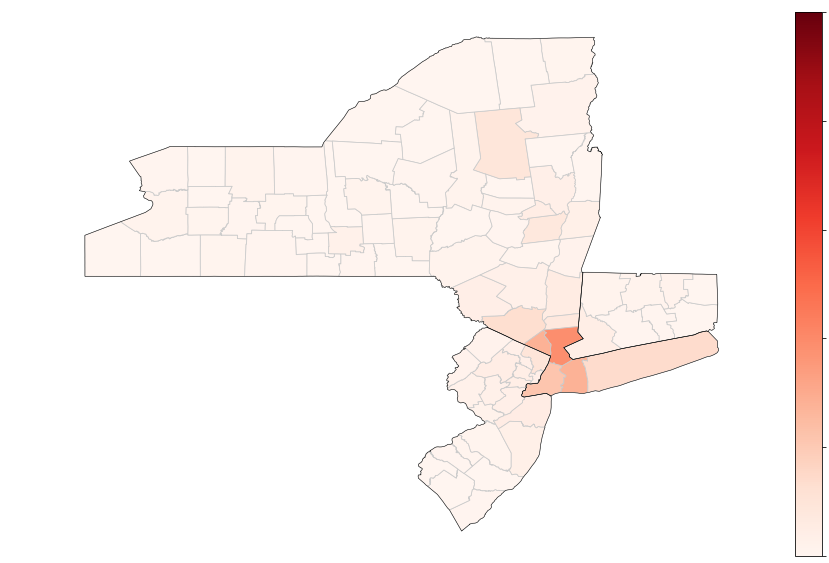

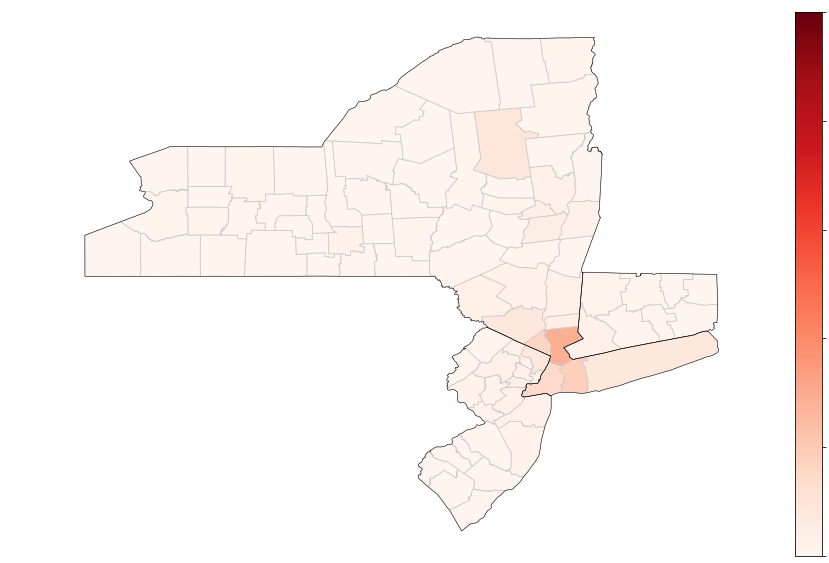

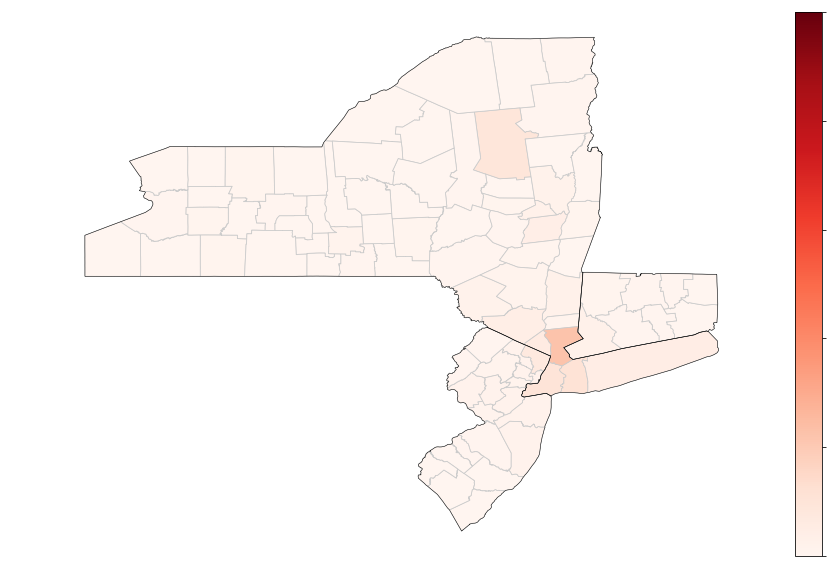

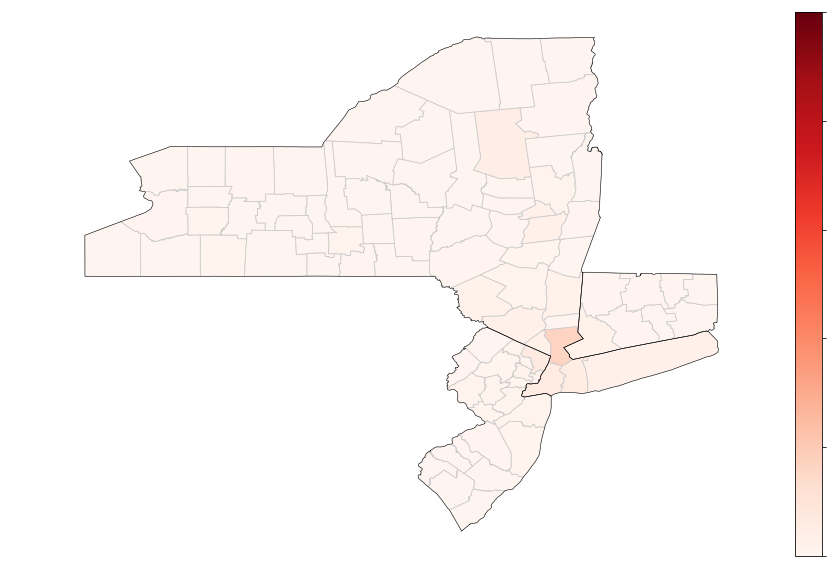

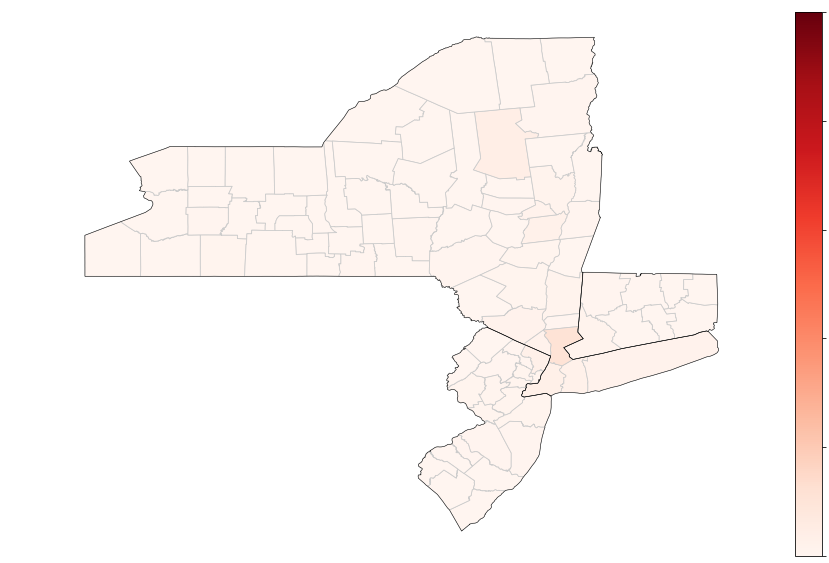

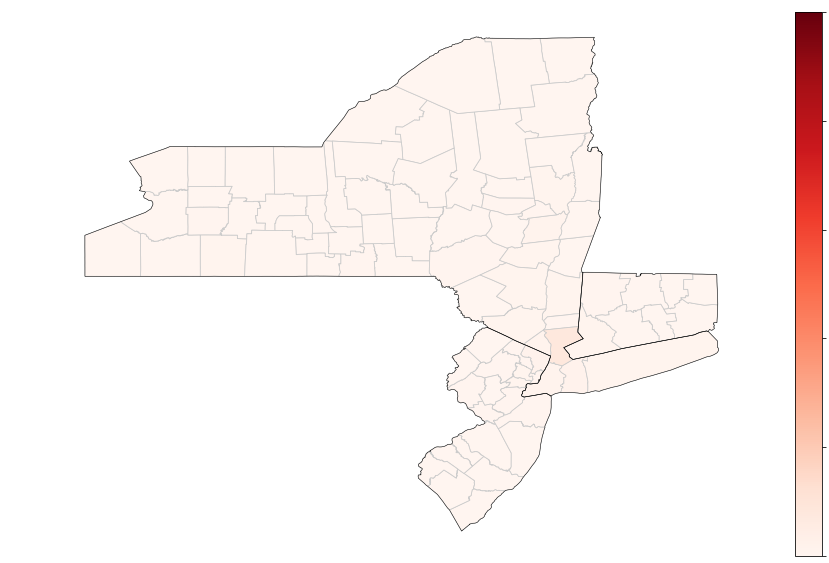

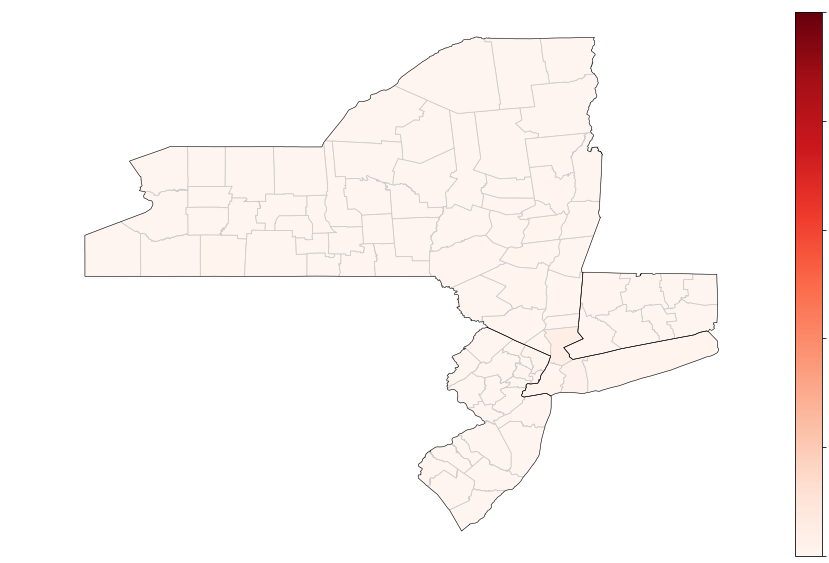

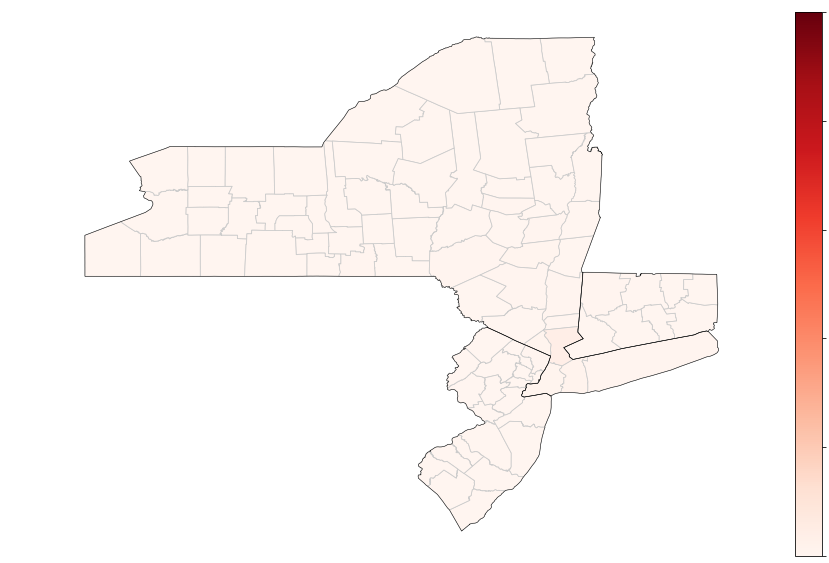

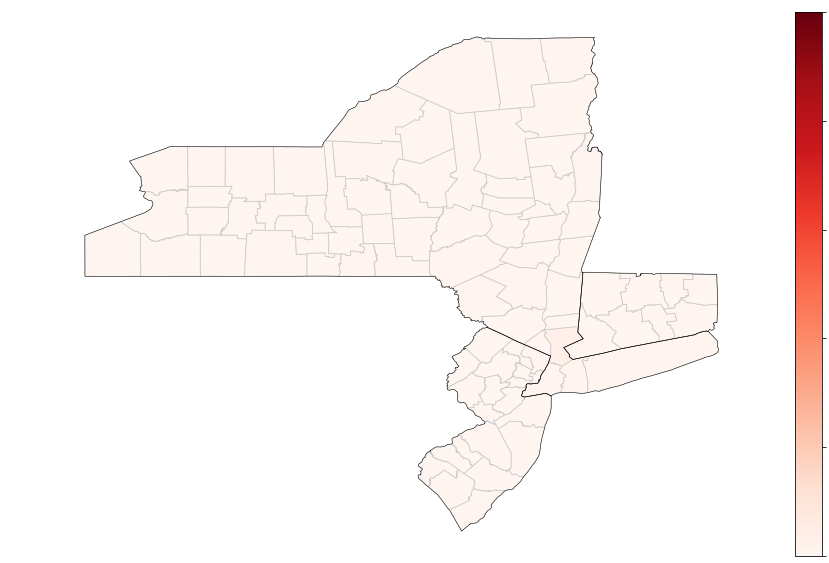

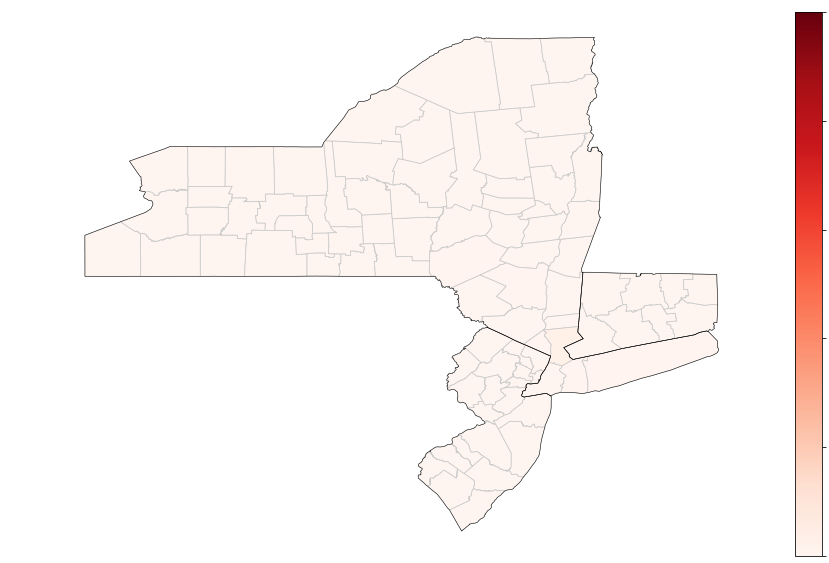

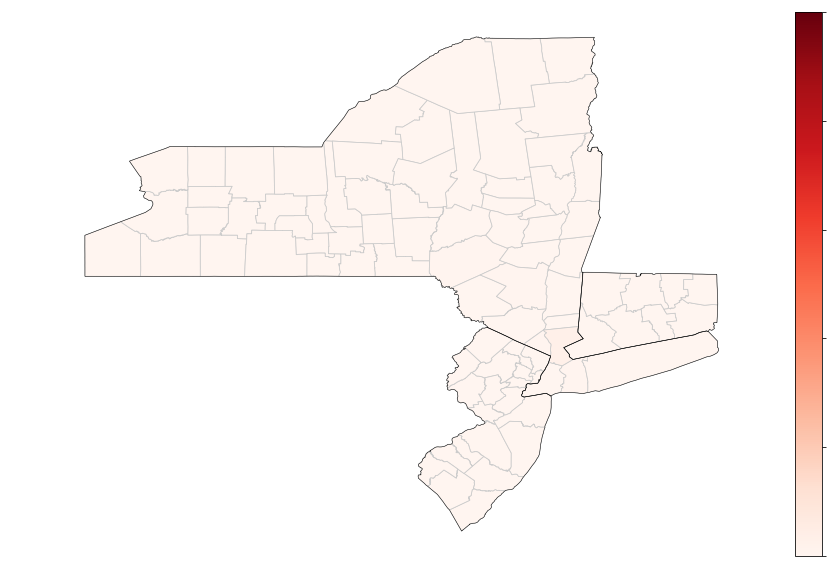

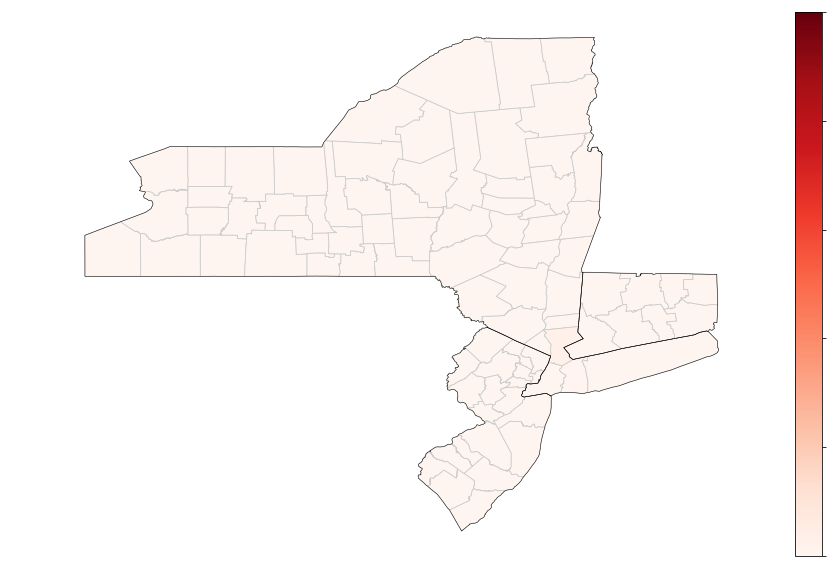

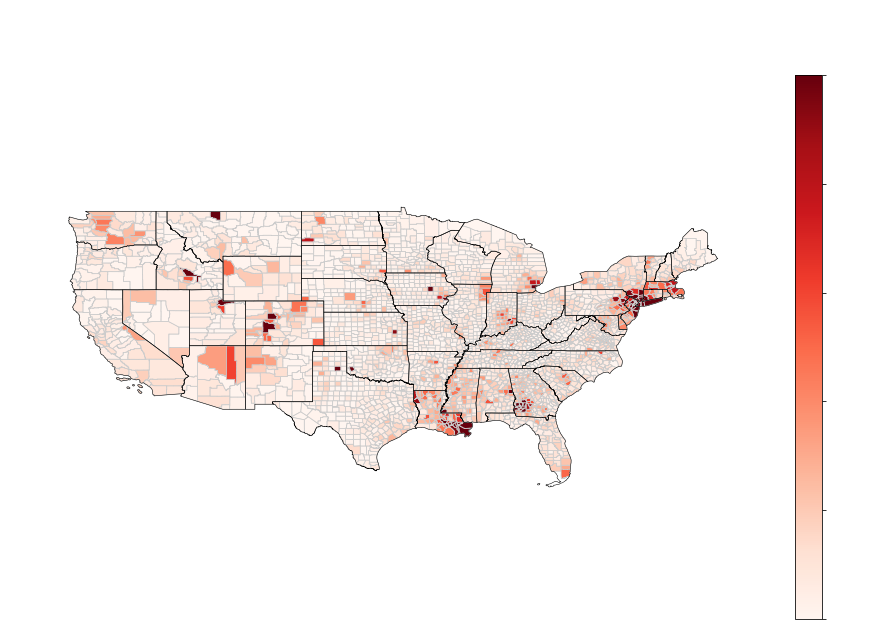

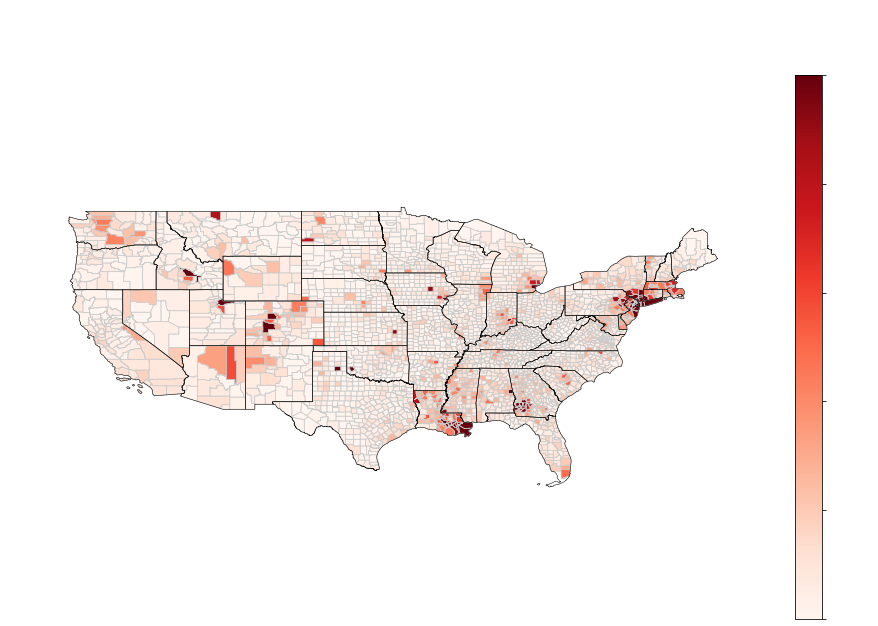

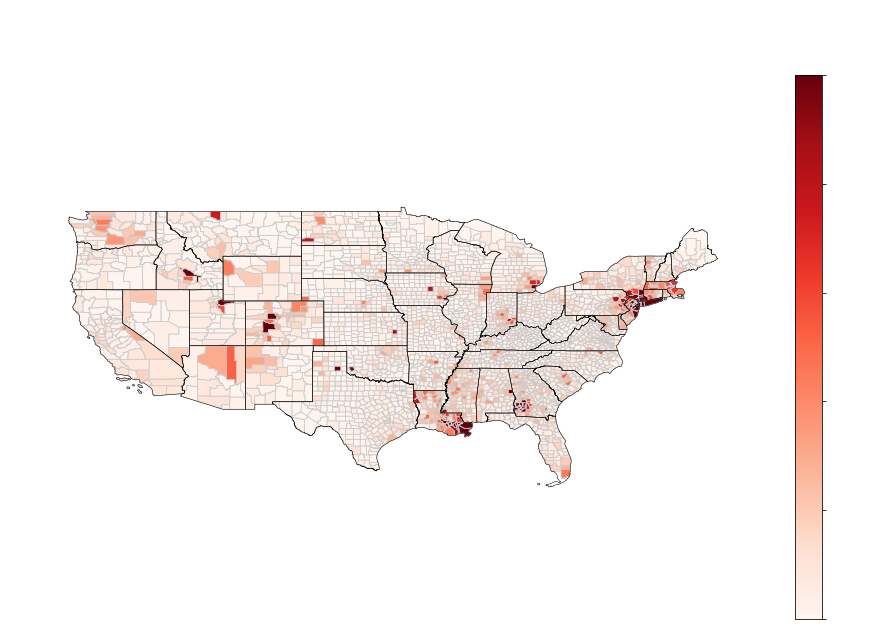

In [38]:
for key, meta in metadata.items():
    variable = meta.get("variable")
    vmin = meta.get("vmin")
    vmax = meta.get("vmax")
    title = meta.get("title")
    threshold = meta.get("threshold")

    for output_path, v in shapefiles.items():
        output_path = f"maps/{key}/{output_path}"
        os.makedirs(output_path, exist_ok=True)

        ct, st = v

        for date in sorted(
            covid_df.loc[covid_df.date >= "2020-03-11", "date"].unique(), reverse=True
        ):

            # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
            filepath = os.path.join(output_path, f"{date}.png")
            if not os.path.exists(f"{os.getcwd()}/{filepath}"):
                # merge shapefile with daily covid data
                merged = ct.merge(
                    covid_df.loc[covid_df["date"] == date], how="left", on="fips"
                )
                # fill nans for counties without cases
                merged[variable].fillna(0, inplace=True)
                counties = merged.plot(
                    column=variable,
                    cmap="Reds",
                    figsize=(16, 10),
                    linewidth=0.8,
                    edgecolor="0.8",
                    vmin=vmin,
                    vmax=vmax,
                    legend=True,
                    norm=plt.Normalize(vmin=vmin, vmax=vmax),
                )

                fig = st.geometry.boundary.plot(
                    color=None, edgecolor="k", linewidth=0.5, ax=counties
                )  # Use your second dataframe
                fig.axis("off")

                # add a title
                fig.set_title(
                    title, fontdict={"fontsize": "25", "fontweight": "3"},
                )

                # position the annotation to the bottom left
                date_str = datetime.datetime.strptime(date, "%Y-%m-%d").strftime(
                    "%B %d, %Y"
                )
                fig.annotate(
                    date_str,
                    xy=(0.1, 0.225),
                    xycoords="figure fraction",
                    horizontalalignment="left",
                    verticalalignment="top",
                    fontsize=35,
                )
                fig.annotate(
                    "Source: The New York Times - github.com/nytimes/covid-19-data",
                    xy=(0.1, 0.155),
                    xycoords="figure fraction",
                    horizontalalignment="left",
                    verticalalignment="top",
                    fontsize=10,
                )
                #             if ("us" not in output_path):
                # counties with more than 100 cases per 100,000
                cases = ""
                for x in (
                    merged.loc[
                        merged[variable] > threshold,
                        ["state", "county", variable, variable.split("_")[0]],
                    ]
                    .sort_values(by=variable, ascending=False)
                    .values
                ):
                    if key == "cases":
                        cases += f"{x[0]}-{x[1]}: {int(x[2])}+ ({int(x[3])})\n"
                    else:
                        cases += f"{x[0]}-{x[1]}: {round(x[2], 3)}+ ({int(x[3])})\n"
                fig.annotate(
                    cases,
                    xy=(0.85, 0.875),
                    xycoords="figure fraction",
                    horizontalalignment="left",
                    verticalalignment="top",
                    fontsize=8,
                )

                chart = fig.get_figure()

                chart.savefig(filepath, dpi=100)
#         plt.close(chart)

In [36]:
covid_df.loc[
    (covid_df["state"] == "Georgia") & (covid_df.date == "2020-04-12"),
].sort_values(by="deaths", ascending=False)

date      county    state   fips  cases  deaths  \
51571  2020-04-12   Dougherty  Georgia  13095   1178      72   
51584  2020-04-12      Fulton  Georgia  13121   1495      50   
51557  2020-04-12        Cobb  Georgia  13067    728      35   
51590  2020-04-12    Gwinnett  Georgia  13135    701      19   
51532  2020-04-12      Bartow  Georgia  13015    213      16   
...           ...         ...      ...    ...    ...     ...   
51623  2020-04-12      Miller  Georgia  13201     11       0   
51622  2020-04-12  Meriwether  Georgia  13199     23       0   
51621  2020-04-12    McIntosh  Georgia  13191      3       0   
51619  2020-04-12      Marion  Georgia  13197     10       0   
51525  2020-04-12     Appling  Georgia  13001     10       0   

       POP_ESTIMATE_2018  cases_per_100000  deaths_per_100000  
51571            91243.0       1291.057944          78.910163  
51584          1050114.0        142.365496           4.761388  
51557           756865.0         96.186242           4.624339  
51590           927781.0         75.556624           2.047897  
51532           106408.0        200.172919          15.036463  
...                  ...               ...                ...  
51623             5686.0        193.457615           0.000000  
51622            21068.0        109.170306           0.000000  
51621            14340.0         20.920502           0.000000  
51619             8351.0        119.746138           0.000000  
51525            18507.0         54.033609           0.000000  

[158 rows x 9 columns]

In [ ]:
!for i in maps/cases/tristate/*.png; do sips -s format jpeg -s formatOptions 70 "${i}" --out "${i%png}jpg"; done

# use jpgs to make gif using imagemagick
!convert -delay 60 -loop 0 maps/cases/tristate/*.jpg maps/cases/tristate/covid.gif

!for i in maps/cases/northeast/*.png; do sips -s format jpeg -s formatOptions 70 "${i}" --out "${i%png}jpg"; done
    

# use jpgs to make gif using imagemagick
!convert -delay 60 -loop 0 maps/cases/northeast/*.jpg maps/cases/northeast/covid.gif

!for i in maps/cases/us/*.png; do sips -s format jpeg -s formatOptions 70 "${i}" --out "${i%png}jpg"; done
    

# use jpgs to make gif using imagemagick
!convert -delay 60 -loop 0 maps/cases/us/*.jpg maps/cases/us/covid.gif

In [ ]:
!for i in maps/deaths/tristate/*.png; do sips -s format jpeg -s formatOptions 70 "${i}" --out "${i%png}jpg"; done

# use jpgs to make gif using imagemagick
!convert -delay 60 -loop 0 maps/deaths/tristate/*.jpg maps/deaths/tristate/covid.gif

!for i in maps/deaths/northeast/*.png; do sips -s format jpeg -s formatOptions 70 "${i}" --out "${i%png}jpg"; done
    

# use jpgs to make gif using imagemagick
!convert -delay 60 -loop 0 maps/deaths/northeast/*.jpg maps/deaths/northeast/covid.gif

!for i in maps/deaths/us/*.png; do sips -s format jpeg -s formatOptions 70 "${i}" --out "${i%png}jpg"; done
    

# use jpgs to make gif using imagemagick
!convert -delay 60 -loop 0 maps/deaths/us/*.jpg maps/deaths/us/covid.gif